### Churn Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import model_selection
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, plot_confusion_matrix, roc_curve
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import warnings
warnings.filterwarnings("ignore")
plt.style.use('seaborn-muted')
%matplotlib inline

### Initial Data Cleaning

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/anilak1978/customer_churn/master/Churn_Modeling.csv")
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [3]:
#Checking the no. of rows and columns
df.shape

(10000, 14)

In [4]:
# Checking for the number of null values present in each feature

round((df.isnull().sum() * 100)/(df.shape[0]),2)

#There are no null values

RowNumber          0.0
CustomerId         0.0
Surname            0.0
CreditScore        0.0
Geography          0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [6]:
df.drop(['RowNumber', 'CustomerId','Surname',], axis=1, inplace=True)

In [7]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


### Exploratory Data Analysis

### Visualizing Categorical Features

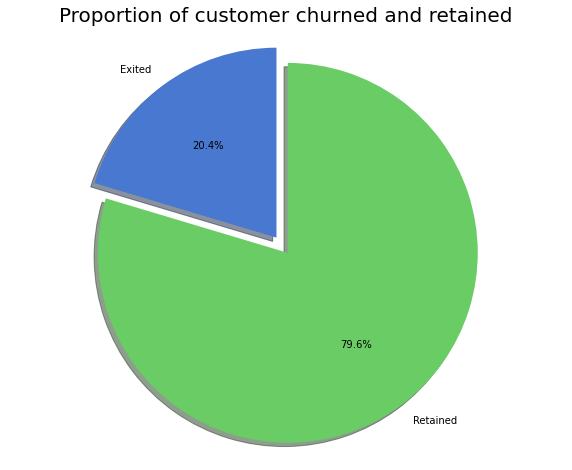

In [8]:
labels = 'Exited', 'Retained'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size = 20)
plt.show()

#So about 20% of the customers have churned.
#So the baseline model could be to predict that 20% of the customers will churn. 
#Given 20% is a small number, we need to ensure that the chosen model does predict with great accuracy this 20% as it is of interest to the bank to identify and keep this bunch as opposed to accurately predicting the customers that are retained.

In [9]:
# Performing EDA on the Categorical columns (Hidden Input)
import matplotlib.pyplot as plt

cat_cols = list(df.select_dtypes("object"))
print(cat_cols)

['Geography', 'Gender']


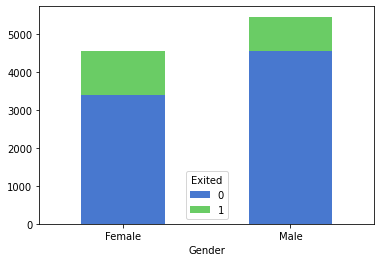

In [10]:
#1. Gender

ax = pd.crosstab(df.Gender, df['Exited']).plot.bar(stacked=True)
plt.xticks(rotation=None)
plt.show()

#It seems there is no huge difference between male and female

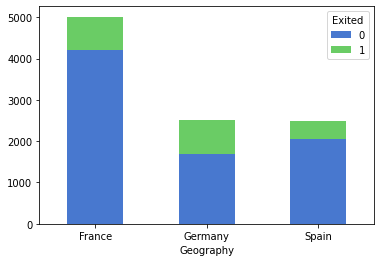

In [11]:
#2. Geography

ax = pd.crosstab(df.Geography, df['Exited']).plot.bar(stacked=True)
plt.xticks(rotation=None)
plt.show()

'\nMajority of the data is from persons from France. However, the proportion of churned customers is with inversely related to the population of customers alluding to the bank possibly having a problem (maybe not enough customer service resources allocated) in the areas where it has fewer clients.\nThe proportion of female customers churning is also greater than that of male customers\nInterestingly, majority of the customers that churned are those with credit cards. Given that majority of the customers have credit cards could prove this to be just a coincidence.\nUnsurprisingly the inactive members have a greater churn. Worryingly is that the overall proportion of inactive mebers is quite high suggesting that the bank may need a program implemented to turn this group to active customers as this will definately have a positive impact on the customer churn.\n'

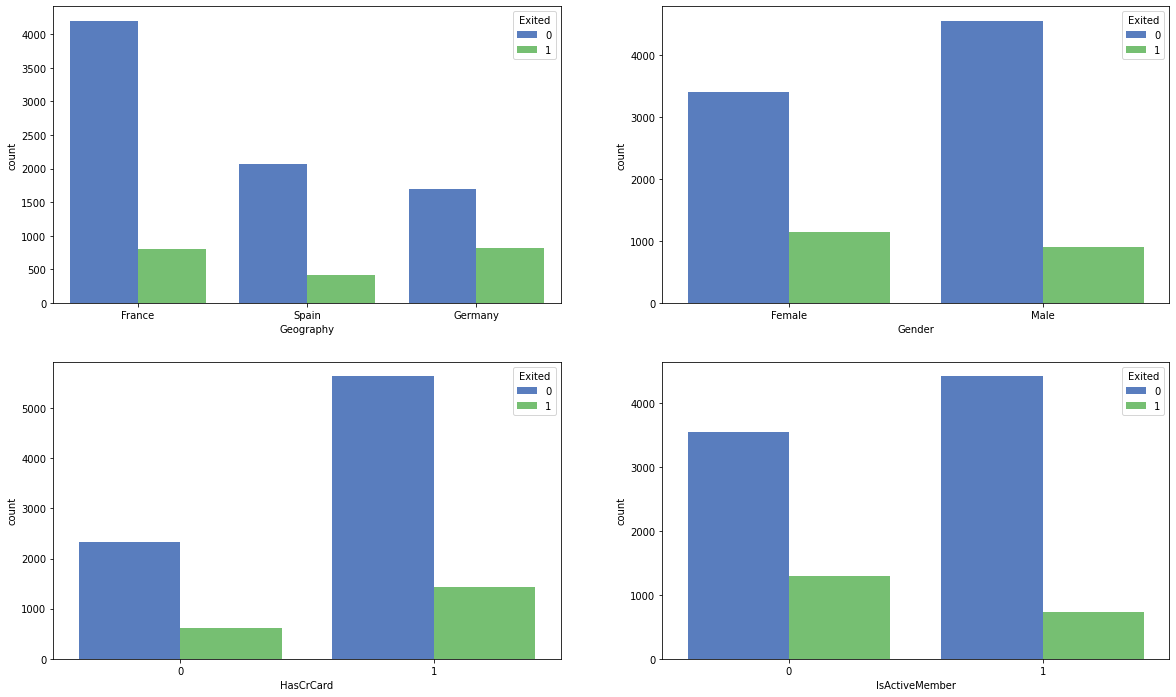

In [12]:
 # We first review the 'Status' relation with categorical variables
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='Geography', hue = 'Exited',data = df, ax=axarr[0][0])
sns.countplot(x='Gender', hue = 'Exited',data = df, ax=axarr[0][1])
sns.countplot(x='HasCrCard', hue = 'Exited',data = df, ax=axarr[1][0])
sns.countplot(x='IsActiveMember', hue = 'Exited',data = df, ax=axarr[1][1])


#We note the following:
'''
Majority of the data is from persons from France. However, the proportion of churned customers is with inversely related to the population of customers alluding to the bank possibly having a problem (maybe not enough customer service resources allocated) in the areas where it has fewer clients.
The proportion of female customers churning is also greater than that of male customers
Interestingly, majority of the customers that churned are those with credit cards. Given that majority of the customers have credit cards could prove this to be just a coincidence.
Unsurprisingly the inactive members have a greater churn. Worryingly is that the overall proportion of inactive mebers is quite high suggesting that the bank may need a program implemented to turn this group to active customers as this will definately have a positive impact on the customer churn.
'''

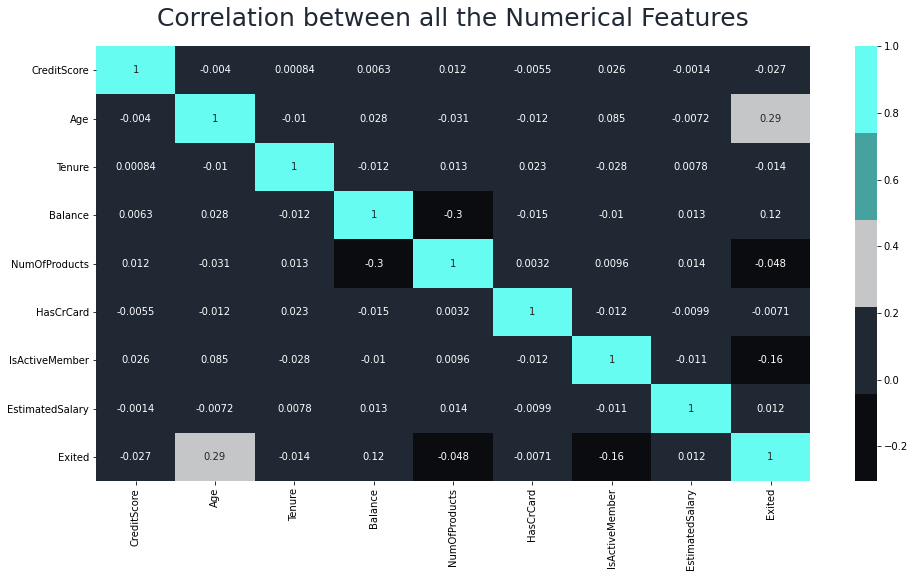

In [13]:
# Creating a heatmap of the numerical column (Hidden Input)

heat = df.corr()
plt.figure(figsize=[16,8])
plt.title("Correlation between all the Numerical Features", size=25, pad=20, color='#1f2833')
sns.heatmap(heat, cmap=['#0b0c10', '#1f2833','#c5c6c7','#45a29e','#66fcf1'], annot=True)
plt.show()

Text(17.95433159722222, 0.5, 'Estimated Salary')

<Figure size 1440x1440 with 0 Axes>

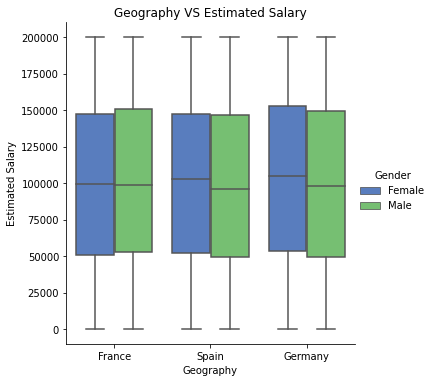

In [14]:
# Looking at Geography and Gender Distribution against Estimated Salary
plt.figure(figsize=(20,20))
sns.catplot(x="Geography", y="EstimatedSalary", hue="Gender", kind="box", data=df)
plt.title("Geography VS Estimated Salary")
plt.xlabel("Geography")
plt.ylabel("Estimated Salary")

<AxesSubplot:xlabel='Exited', ylabel='EstimatedSalary'>

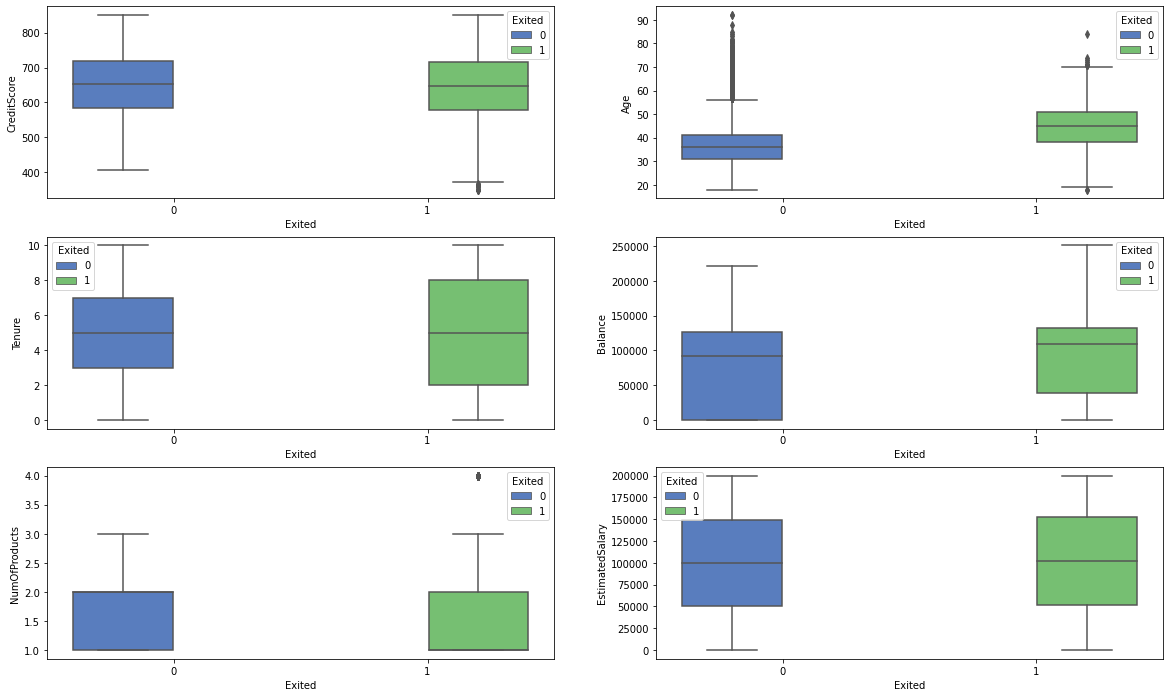

In [15]:
# Relations based on the continuous data attributes
fig, axarr = plt.subplots(3, 2, figsize=(20, 12))
sns.boxplot(y='CreditScore',x = 'Exited', hue = 'Exited',data = df, ax=axarr[0][0])
sns.boxplot(y='Age',x = 'Exited', hue = 'Exited',data = df , ax=axarr[0][1])
sns.boxplot(y='Tenure',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][0])
sns.boxplot(y='Balance',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][1])
sns.boxplot(y='NumOfProducts',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][0])
sns.boxplot(y='EstimatedSalary',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][1])

<AxesSubplot:xlabel='Age', ylabel='CreditScore'>

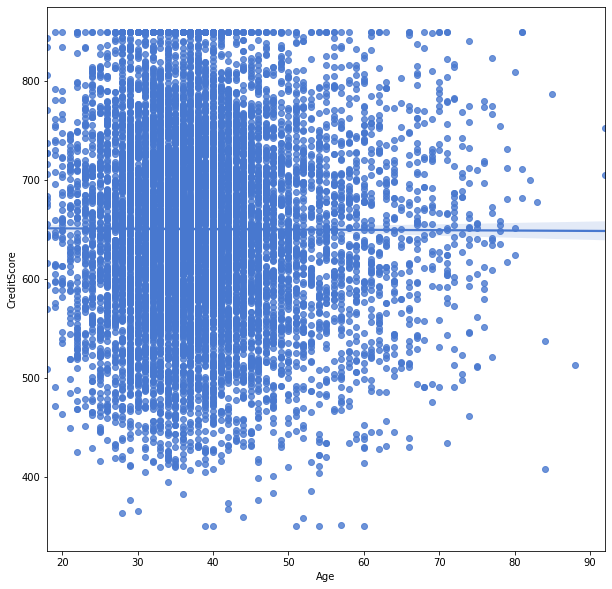

In [16]:
# Looking at linear relationship between Age and CreditScore
plt.figure(figsize=(10,10))
sns.regplot(x="Age", y="CreditScore", data=df)

### Building the models

In [17]:
# Selecting and Preparing the Feature Set and Target
X = df[["CreditScore", "Geography", "Gender", "Age", "Tenure", "EstimatedSalary"]].values
y = df[["Exited"]]
X[0:5], y[0:5]

(array([[619, 'France', 'Female', 42, 2, 101348.88],
        [608, 'Spain', 'Female', 41, 1, 112542.58],
        [502, 'France', 'Female', 42, 8, 113931.57],
        [699, 'France', 'Female', 39, 1, 93826.63],
        [850, 'Spain', 'Female', 43, 2, 79084.1]], dtype=object),
    Exited
 0       1
 1       0
 2       1
 3       0
 4       0)

In [18]:
# preprocessing categorical variables
from sklearn import preprocessing
geography=preprocessing.LabelEncoder()
geography.fit(["France", "Spain", "Germany"])
X[:,1]=geography.transform(X[:,1])

gender = preprocessing.LabelEncoder()
gender.fit(["Female", "Male"])
X[:,2]=gender.transform(X[:,2])

In [19]:
# split train and test data
from sklearn.model_selection import train_test_split
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.2, random_state=3)


In [20]:
# create model using DecisionTree Classifier and fit training data
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier()
dt_model.fit(X_trainset, y_trainset)

DecisionTreeClassifier()

In [21]:
# create prediction
dt_pred = dt_model.predict(X_testset)
dt_pred[0:5]

array([0, 0, 1, 0, 0], dtype=int64)

In [22]:
# Evaluating the prediction model
from sklearn import metrics
metrics.accuracy_score(y_testset, dt_pred)

0.726

In [23]:
# create Random Forest Decision Tree model
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_trainset, y_trainset.values.ravel())

RandomForestClassifier()

In [24]:
# create prediction using rf_model
rf_pred = rf_model.predict(X_testset)
rf_pred[0:5]

array([0, 0, 1, 0, 0], dtype=int64)

In [25]:
# evaluate the model
metrics.accuracy_score(y_testset, rf_pred)

0.808

In [52]:
xgb_model = xgb.XGBClassifier(random_state=69, use_label_encoder=False, n_jobs=-1)

xgb_model.fit(X_trainset, y_trainset)

[11:31:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=69,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [53]:
xgb_pred =xgb_model.predict(X_testset)
xgb_model.score(X_testset, y_testset)


0.82

Text(33.0, 0.5, 'True')

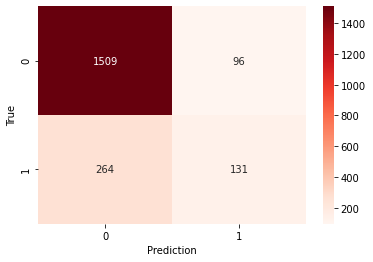

In [54]:
sns.heatmap(confusion_matrix(y_testset,xgb_pred),cmap='Reds',annot=True,fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True')

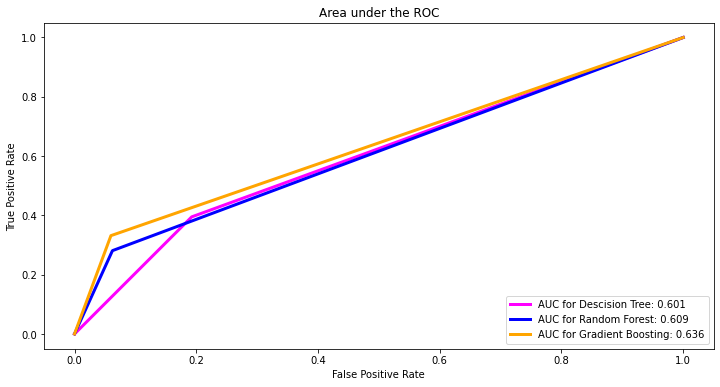

In [28]:
#roc's
roc_dt=roc_curve(y_true=y_testset,y_score=dt_pred)
roc_rf=roc_curve(y_true=y_testset,y_score=rf_pred)
roc_xgb = roc_curve(y_true=y_testset,y_score=xgb_pred)

#PLot graph
plt.figure(figsize=(12,6))
plt.plot(roc_dt[0],roc_dt[1],color='magenta',lw=3,label='AUC for Descision Tree: %.3f' %(roc_auc_score(y_true=y_testset,y_score=dt_pred)))
plt.plot(roc_rf[0],roc_rf[1],color='blue',lw=3,label='AUC for Random Forest: %.3f' %(roc_auc_score(y_true=y_testset,y_score=rf_pred)))
plt.plot(roc_xgb[0],roc_xgb[1],color='orange',lw=3,label='AUC for Gradient Boosting: %.3f' %(roc_auc_score(y_true=y_testset,y_score=xgb_pred)))
plt.title('Area under the ROC')
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


### Model Evaluation

In [29]:

models = []


models.append(('Decision Tree Classifier',DecisionTreeClassifier(criterion = 'entropy', random_state = 0)))
models.append(('Random Forest', RandomForestClassifier(n_estimators=100, criterion = 'entropy', random_state = 0)))
models.append(('XG Boost',  xgb.XGBClassifier(random_state=69, use_label_encoder=False, n_jobs=-1)))

In [30]:
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.metrics import f1_score, precision_score, recall_score, fbeta_score


col = ['Algorithm', 'Accuracy', 'Precision','Recall', 'F1 Score', 'F2 Score']
model_results = pd.DataFrame(columns=col)
i = 0

for name, model in models:
    classifier = model
    classifier.fit(X_trainset, y_trainset)
    y_pred = classifier.predict(X_testset)
    acc = accuracy_score(y_testset, y_pred )
    prec = precision_score(y_testset, y_pred )
    rec = recall_score(y_testset, y_pred )
    f1 = f1_score(y_testset, y_pred )
    f2 = fbeta_score(y_testset, y_pred, beta=2.0)
    model_results.loc[i] = [name,acc,prec,rec,f1,f2]
    
    i += 1
    
model_results.sort_values(by=["Precision","Recall","F2 Score"], ascending=False)

[10:55:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Algorithm,Accuracy,Precision,Recall,F1 Score,F2 Score
2,XG Boost,0.8200,0.577093,0.331646,0.421222,0.362479
1,Random Forest,0.8135,0.552885,0.291139,0.381426,0.321588
0,Decision Tree Classifier,0.7390,0.353349,0.387342,0.369565,0.380030


In [31]:

#Evaluating Model Results:
acc_results = []
auc_results = []
names = []
roc =[]
# set table to table to populate with performance results
col = ['Algorithm', 'ROC AUC Mean', 'ROC AUC STD', 
       'Accuracy Mean', 'Accuracy STD']
model_results = pd.DataFrame(columns=col)
i = 0
# Evaluate each model using k-fold cross-validation:
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=0)

    # accuracy scoring:
    cv_acc_results = model_selection.cross_val_score(model, X_trainset, y_trainset, cv=kfold, scoring='accuracy')

    # roc_auc scoring:
    cv_auc_results = model_selection.cross_val_score(model, X_trainset, y_trainset, cv=kfold, scoring='roc_auc')
    
    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)
    names.append(name)
    
    model_results.loc[i] = [name,
                         round(cv_auc_results.mean()*100, 2),
                         round(cv_auc_results.std()*100, 2),
                         round(cv_acc_results.mean()*100, 2),
                         round(cv_acc_results.std()*100, 2)
                         ]
    i += 1
    
model_results.sort_values(by=['ROC AUC Mean'], ascending=False)

[10:55:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:55:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:55:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:55:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

,Algorithm,ROC AUC Mean,ROC AUC STD,Accuracy Mean,Accuracy STD
2,XG Boost,74.17,1.93,80.71,1.11
1,Random Forest,73.94,1.62,80.50,1.29
0,Decision Tree Classifier,60.30,1.96,73.75,1.37


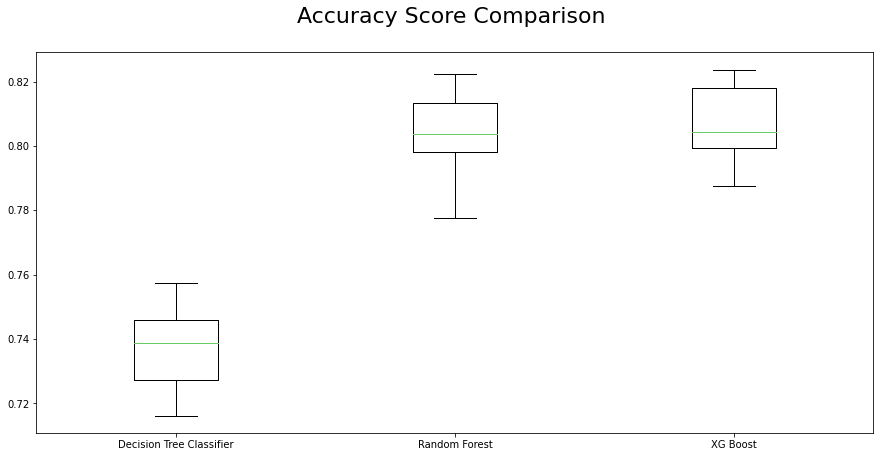

In [32]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
plt.boxplot(acc_results)
ax.set_xticklabels(names)

plt.title('Accuracy Score Comparison \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")

plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

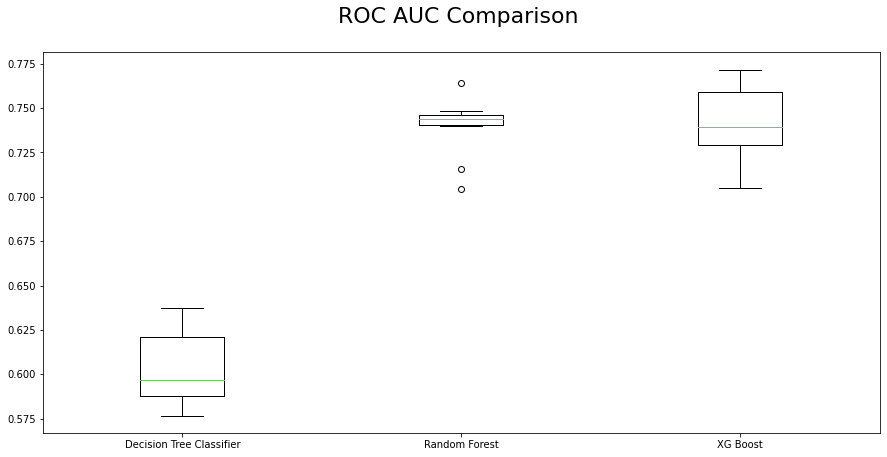

In [33]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
plt.boxplot(auc_results)
ax.set_xticklabels(names)

plt.title('ROC AUC Comparison \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")

plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

### Hyperparameter Tuning

In [34]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [35]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_trainset, y_trainset), ( X_testset, y_testset)]
    
    clf.fit(X_trainset, y_trainset,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_testset)
    accuracy = accuracy_score(y_testset, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [36]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                                                                                 
0.8025                                                                                                                 
SCORE:                                                                                                                 
0.8025                                                                                                                 
SCORE:                                                                                                                 
0.803                                                                                                                  
SCORE:                                                                                                                 
0.808                                                                                                                  
SCORE:                                  

SCORE:                                                                                                                 
0.8025                                                                                                                 
SCORE:                                                                                                                 
0.8025                                                                                                                 
SCORE:                                                                                                                 
0.8025                                                                                                                 
SCORE:                                                                                                                 
0.8025                                                                                                                 
SCORE:                                  

SCORE:                                                                                                                 
0.803                                                                                                                  
SCORE:                                                                                                                 
0.803                                                                                                                  
SCORE:                                                                                                                 
0.8025                                                                                                                 
SCORE:                                                                                                                 
0.808                                                                                                                  
SCORE:                                  

In [37]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.8178138551591502, 'gamma': 1.236053761680807, 'max_depth': 15.0, 'min_child_weight': 5.0, 'reg_alpha': 71.0, 'reg_lambda': 0.4127493018835883}


### Feature Importance

<AxesSubplot:>

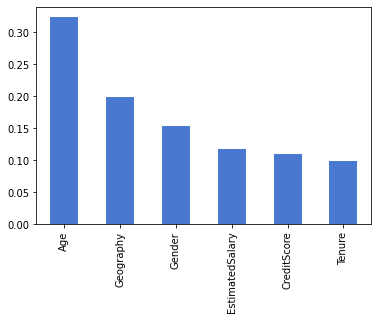

In [39]:
pd.Series(xgb_model.feature_importances_, index = ["CreditScore", "Geography", "Gender", "Age", "Tenure", "EstimatedSalary"]).sort_values(ascending = False).plot(kind = 'bar')

Text(33.0, 0.5, 'True')

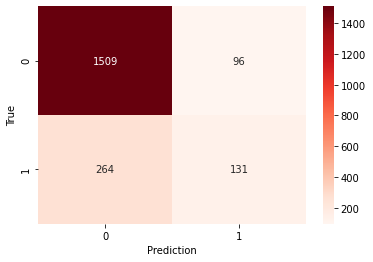

In [50]:
sns.heatmap(confusion_matrix(y_testset,xgb_pred),cmap='Reds',annot=True,fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True')

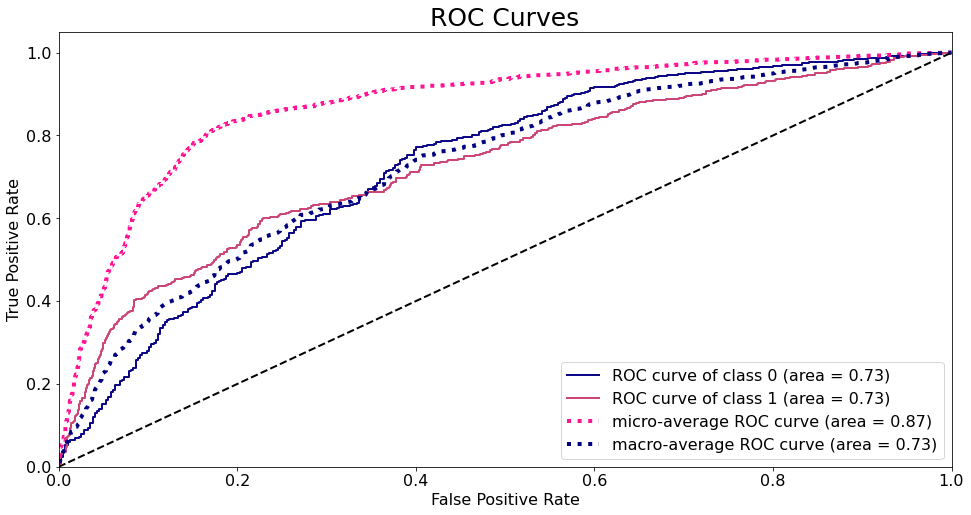

In [58]:
import scikitplot as skplt
y_probas = xgb_model.predict_proba(X_testset) # predicted probabilities generated by sklearn classifier

skplt.metrics.plot_roc(y_testset, y_probas, figsize=(16,8), title_fontsize=25, text_fontsize=16, cmap='plasma')
plt.show()

In [57]:
!pip install scikitplot

ERROR: Could not find a version that satisfies the requirement scikitplot (from versions: none)
ERROR: No matching distribution found for scikitplot
